## Frequency spectra

The most straightforward metric that can quantify the small scale structure in the data is the frequency spectra since the data is collected as a timeseries. 

The obvious issue with this metric is its interpretation, as the measurements are not perfectly Eulerian (at a single point). This implies that comparison to other measurments and theoretical estimates is hindered, but the measurement relative to other depths and other variables from the same data set are still useful. 


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal as sg
import spectrum 
from scipy import stats, fft
import xarray as xr

In [2]:
from cmocean import cm as cmo


In [3]:
import hvplot.xarray

In [4]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [5]:
ds_660_grid = xr.open_dataset('data/ctd_660_vert_binned_29_june_2021.nc')

In [6]:
# Calculate a time axis as YTD
days = ds_660_grid.time - np.datetime64('2019-01-01')
days_round_660 = (days / np.timedelta64(1, 'D')).round()
ds_660_grid['days'] = (days / np.timedelta64(1, 'D'))

In [7]:
ds_660_grid

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, dives: 1007)
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
  * dives         (dives) float64 1.0 1.5 2.0 2.5 ... 508.0 508.5 509.0 509.5
Data variables:
    sigma0        (ctd_pressure, dives) float64 ...
    SA            (ctd_pressure, dives) float64 ...
    CT            (ctd_pressure, dives) float64 ...
    time          (ctd_pressure, dives) datetime64[ns] 2019-04-30T12:15:30.70...
    latitude      (ctd_pressure, dives) float64 ...
    longitude     (ctd_pressure, dives) float64 ...
    days          (ctd_pressure, dives) float64 119.5 119.5 119.5 ... nan nan
Attributes:
    units:          kg/m^3
    comment:        Calculated using GSW
    standard_name:  Potential Density Anomaly
    platform:       glider
    history:        [2021-06-29 12:36:06] (v2021.3) glidertools.cleaning.outl...
    outlier_lims:   [33.83323076 35.65218568]

### Interpolate in time

In [8]:
# Interpolate to a uniform time grid
from scipy import interpolate

def interp_time(ds, var): 
    time_grid = np.arange(120, 205, 1/24)

   
    for i in range(len(ds.ctd_pressure)):
        ds_temp =ds.isel(ctd_pressure=i)
        f = interpolate.interp1d(ds_temp.days, ds_temp[var])
        var_int = f(time_grid)
        
        da_var_int_temp = xr.DataArray(var_int,
                                 dims=["days"],
                                 coords={"days": time_grid, "ctd_pressure": ds_temp.ctd_pressure}
                                 ).rename(var)
        
        if i==0:
            da_var_int = da_var_int_temp
        else:
            da_var_int = xr.concat([da_var_int, da_var_int_temp], dim='ctd_pressure')
        
    return da_var_int

In [9]:
ds_660_time = xr.merge([interp_time(ds_660_grid,'sigma0'),
                        interp_time(ds_660_grid,'CT'),
                        interp_time(ds_660_grid,'SA')])

In [10]:
ds_660_time

<xarray.Dataset>
Dimensions:       (ctd_pressure: 100, days: 2040)
Coordinates:
  * days          (days) float64 120.0 120.0 120.1 120.1 ... 204.9 204.9 205.0
  * ctd_pressure  (ctd_pressure) float64 5.0 15.0 25.0 ... 975.0 985.0 995.0
Data variables:
    sigma0        (ctd_pressure, days) float64 27.04 27.04 27.04 ... 27.86 27.86
    CT            (ctd_pressure, days) float64 3.569 3.585 3.608 ... 2.23 2.231
    SA            (ctd_pressure, days) float64 34.17 34.17 34.17 ... 35.05 35.05

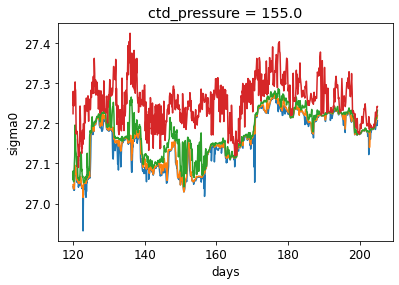

In [11]:
ds_660_time.sigma0.sel(ctd_pressure=15, method='nearest').plot()
ds_660_time.sigma0.sel(ctd_pressure=50, method='nearest').plot()
ds_660_time.sigma0.sel(ctd_pressure=100, method='nearest').plot()
ds_660_time.sigma0.sel(ctd_pressure=150, method='nearest').plot()

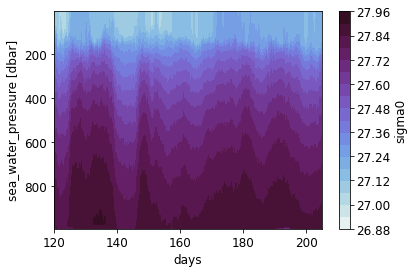

In [13]:
ds_660_time.sigma0.plot.contourf(levels=18, cmap=cmo.dense)
plt.gca().invert_yaxis()

### Multi-taper method

MTM is the best practical method for **estimating** the power spectral density (with limited data), as it gives the best balance between bias and variance. 

Here we use the implementation that is part of: https://pyspectrum.readthedocs.io/en/latest/ref_mtm.html

A nice understandable summary of the method (and comparison to periodogram and windowed estimate) is given in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5343535/ 
or http://jmlilly.net/course/v3/SpectralAnalysisDemo.html

There are two parameters that needs to be selected: 
- NW is the time-half-bandwidth. As described in the above reference this parameter sets the spectral resolution. Larger values would make sharp peaks broader, but also smooth over random spikes in the spectra that are not necessarily associated with periodicities. We will select this by trial and error. 
- k is the number of Slepian windows to be used. We will use the suggested optimal value of [2*NW] -1 .


(1e-06, 1)

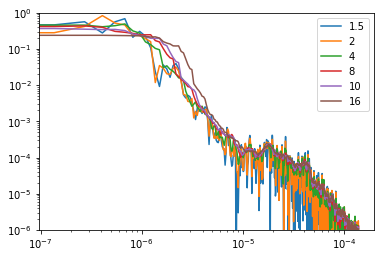

In [324]:
# First figure out what are a good set of parameters to use 
# Broad scale search
data = ds_660_time.sigma0.sel(ctd_pressure=600, method='nearest').values

for NW in [ 1.5, 2, 4, 8, 10, 16]:

    mtm_obj = spectrum.MultiTapering(data - np.mean(data), # remove mean
                                     NW=NW, 
                                     k = int(np.floor(2*NW)-1), 
                                     method='adapt',
                                     NFFT = len(data), 
                                     sampling=1/3600 # the sampling frequency (how large is 1/dt)
                                    )
    mtm_obj.run()
    plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-6, 1])
#plt.xlim([0, 1e-5])

(1e-06, 1)

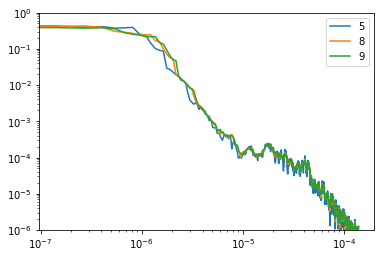

In [327]:
# fine grained
data = ds_660_time.sigma0.sel(ctd_pressure=600, method='nearest').values

for NW in [5,8, 9]:

    mtm_obj = spectrum.MultiTapering(data - np.mean(data),
                      NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                      NFFT = len(data), sampling=1/3600)
    mtm_obj.run()
    plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim([1e-6, 1])

Notice that at large values of NW the shoulder at the lower frequencies starts to extend further into the higher frequencies, artificially steepening the intermediate scale slope. This is to be expected as this parameters sets the width of the narrowband signals, and at values around 10 it would penetrate around a decade of scales.
While taking small values of NW gives a relatively rough spectrum, making it hard to pick out the faint signs of oscillations.  
We will pick a value of 9, as it seems like a reasonable balance, 

#### Apply to all depths in xarray way

In [476]:
def mtm_psd(ds, var):
    NW=10 # fix this based on testing done prior
    da = ds[var] - ds[var].mean('days') # remove a time mean 
    
    for i in range(len(da.ctd_pressure)): 
        
        data = da.isel(ctd_pressure=i)
        
        mtm_obj = spectrum.MultiTapering(data.values,
                          NW=NW, k = int(np.floor(2*NW)-1), method='adapt',
                          NFFT = len(data), sampling=1/3600)
        mtm_obj.run()
        #plt.plot(mtm_obj.frequencies(), mtm_obj.psd, label=NW) 
        
        da_var_freq_temp = xr.DataArray(mtm_obj.psd, 
                                        dims=['freq'],
                                        coords={'freq': 24*3600*np.array(mtm_obj.frequencies()), # convert to per day
                                                'ctd_pressure': data.ctd_pressure}).rename(var)
        
        if i==0:
            da_var_freq = da_var_freq_temp
        else:
            da_var_freq = xr.concat([da_var_freq, da_var_freq_temp], dim='ctd_pressure')
    
    return da_var_freq

In [477]:
ds_660_freq = xr.merge([mtm_psd(ds_660_time, 'sigma0'),
                        mtm_psd(ds_660_time, 'CT'),
                        mtm_psd(ds_660_time, 'SA')])

#### Potential Energy

We consider potential energy instead of simply buoyancy spectrum as it is a dynamically more meaningful option. 


Some details of the theory (Vallis book, Chapter 2): 

Density ($\rho$) can be written in a separable form as: 
\begin{align}
\rho & =  \rho_0 + \delta \rho (x,y,z,t) \\ & = \rho_0 + \hat{\rho} (z) + \rho'(x,y,z,t) \\ & = \tilde{\rho} (z) + \rho'(x,y,z,t)
\end{align}
where $|\delta \rho|, |\hat{\rho}|, |\rho'| << \rho_0$

Buoyancy is defined as 
\begin{align}
b & = -g \delta \rho / \rho_0  \\ & = -g ( \hat{\rho} (z) / \rho_0 + \rho' (x,y,z,t) /\rho_0 
\\ & = \tilde{b}(z) + b' [m/s^2]
\end{align}

and $N^2 = d \tilde{b}/ dz [1/s^2]$. 
So PE can be defined as $\frac{1}{2} \frac{<b'^2>}{ N^2} [m^2/s^2]$.


In [478]:
# Practically define tilde as the average
rho_tilde = ds_660_time.sigma0.mean('days')
rho_prime = ds_660_time.sigma0 - rho_tilde

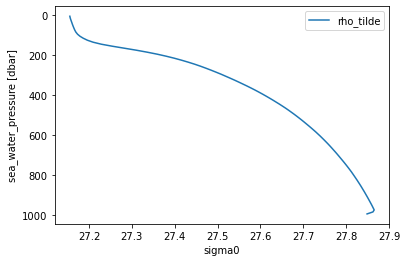

In [479]:
rho_tilde.plot(y='ctd_pressure', label='rho_tilde')
plt.gca().invert_yaxis()
plt.legend()

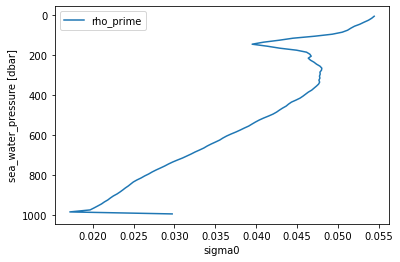

In [430]:
np.abs(rho_prime).mean('days').plot(y='ctd_pressure', label='rho_prime')
plt.gca().invert_yaxis()
plt.legend()

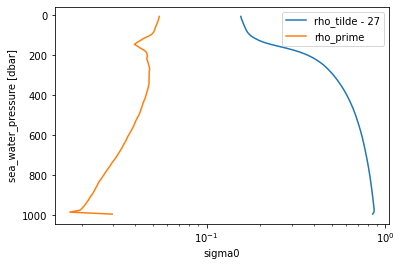

In [431]:
# Here we see that rho' is really much smaller than rho_tilde.
(rho_tilde-27).plot(y='ctd_pressure', label='rho_tilde - 27') # Subtract 27 just to show that rho_0 can vary
np.abs(rho_prime).mean('days').plot(y='ctd_pressure', label='rho_prime')
plt.xscale('log')
plt.gca().invert_yaxis()
plt.legend()

In [480]:
g = 9.81
rho_0 = 1000
b_tilde = - (g*rho_tilde/rho_0).rename('b_tilde')
b_prime = - (g*rho_prime/rho_0).rename('b_prime')

In [481]:
N2 = (b_tilde.diff('ctd_pressure') / (-b_tilde.ctd_pressure).diff('ctd_pressure')).rename('N2')
# need '-' as the Z should be increasing towards the surface

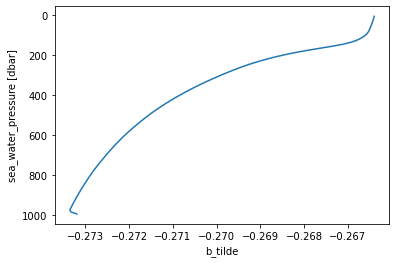

In [482]:
b_tilde.plot(y='ctd_pressure')
plt.gca().invert_yaxis()

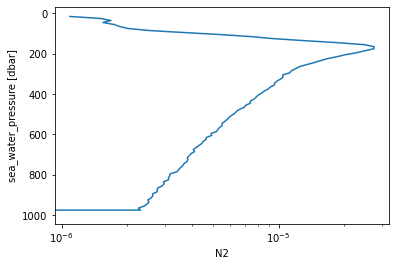

In [483]:
N2.plot(y='ctd_pressure')
plt.gca().invert_yaxis()
plt.xscale('log')

In [484]:
PE_spec = 0.5*(g**2)*ds_660_freq.sigma0/N2 # the spectrum of buoyancy

In [485]:
PE_spec

<xarray.DataArray (ctd_pressure: 99, freq: 1021)>
array([[ 3.29795366e+07,  3.29279847e+07,  3.18139624e+07, ...,
         5.43774016e+02,  5.35199686e+02,  5.45674879e+02],
       [ 2.37301988e+07,  2.37058205e+07,  2.29001225e+07, ...,
         1.39738374e+02,  1.43789984e+02,  1.42351132e+02],
       [ 2.11061100e+07,  2.10671984e+07,  2.03232528e+07, ...,
         7.07239431e+01,  7.28752064e+01,  7.61148980e+01],
       ...,
       [ 2.25419464e+06,  2.23808787e+06,  2.12488041e+06, ...,
         2.66872397e+00,  2.38996984e+00,  2.25837027e+00],
       [-1.40320310e+06, -1.39223126e+06, -1.32401016e+06, ...,
        -1.82223942e+00, -1.78868829e+00, -1.77315543e+00],
       [-1.92595668e+06, -1.92230424e+06, -1.85758215e+06, ...,
        -8.07848192e-03, -9.04367807e-03, -7.97376470e-03]])
Coordinates:
  * ctd_pressure  (ctd_pressure) float64 15.0 25.0 35.0 ... 975.0 985.0 995.0
  * freq          (freq) float64 0.0 0.01176 0.02353 ... 11.98 11.99 12.0

#### Line plots

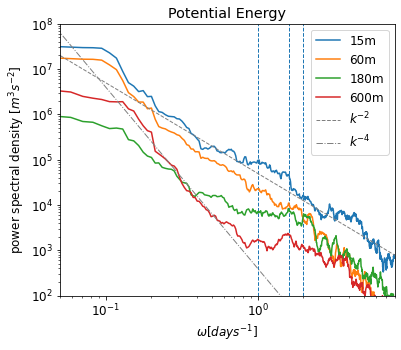

In [551]:
plt.figure(figsize=(6,5))
for i in [15, 60, 180, 600]:
        PE_spec.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = PE_spec.freq
plt.plot(freq, 5e4*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 4e2*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='upper right')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e2, 1e8, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Potential Energy')

plt.ylim([1e2, 1e8])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])

plt.savefig('figures/PE_line_spec.pdf')

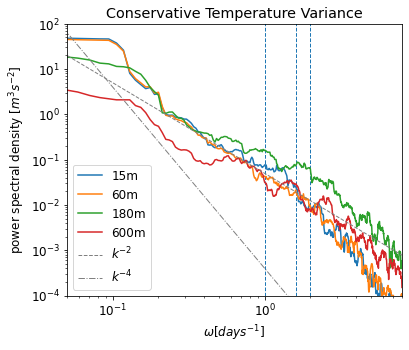

In [552]:
plt.figure(figsize=(6,5))

for i in [15, 60, 180, 600]:
        ds_660_freq.CT.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = PE_spec.freq
plt.plot(freq, 5e-2*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 4e-4*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Conservative Temperature Variance')

plt.ylim([1e-4, 1e2])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])
plt.savefig('figures/CT_line_spec.pdf')

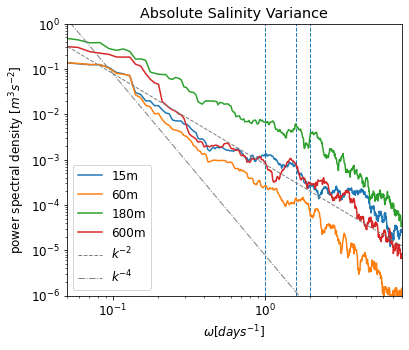

In [553]:
plt.figure(figsize=(6,5))

for i in [15, 60, 180, 600]:
        ds_660_freq.SA.sel(ctd_pressure=i ,method='nearest').plot(label=str(i)+'m')
        
# Some lines        
freq = PE_spec.freq
plt.plot(freq, 8e-4*freq**-2, label='$k^{-2}$', linestyle='--', color='gray', linewidth=1)
plt.plot(freq, 8e-6*freq**-4, label='$k^{-4}$', linestyle='-.', color='gray', linewidth=1)
#plt.loglog(fneg, p[np.where(f < 0)])
#plt.loglog(fpos, p[np.where(f >= 0)])

plt.legend(loc='lower left')
#plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 1e-4, 1e5, linestyles='--', linewidth=1)
plt.vlines([24/15, 24/12, 24/24], 1e-6, 1e5, linestyles='--', linewidth=1)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$\omega [days^{-1}]$')
plt.ylabel('power spectral density $[m^3 s^{-2}]$')
plt.title('Absolute Salinity Variance')

plt.ylim([1e-6, 1e0])
#plt.xlim([5e-7, 1/6/3600])
plt.xlim([1/20, 24/3])
plt.savefig('figures/SA_line_spec.pdf')

#### Depth-Frequency plots

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/xarray/plot/plot.py:991: UserWarning: The following kwargs were not used by contour: 'rasterize'
  primitive = ax.contourf(x, y, z, **kwargs)


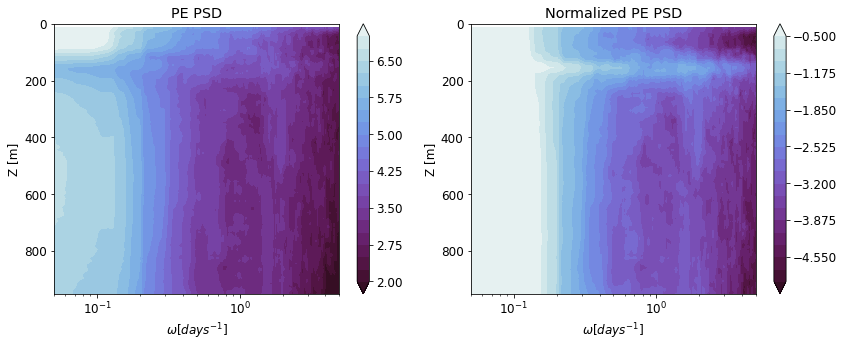

In [559]:
plt.figure(figsize=(12,5))
plt.subplot(121)
np.log10(PE_spec).plot.contourf(levels=np.linspace(2, 7, 21), cmap=cmo.dense_r)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('PE PSD')

plt.subplot(122)
np.log10((PE_spec / PE_spec.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21), cmap=cmo.dense_r)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized PE PSD')

plt.tight_layout()
plt.savefig('figures/PE_depth_spec.pdf')

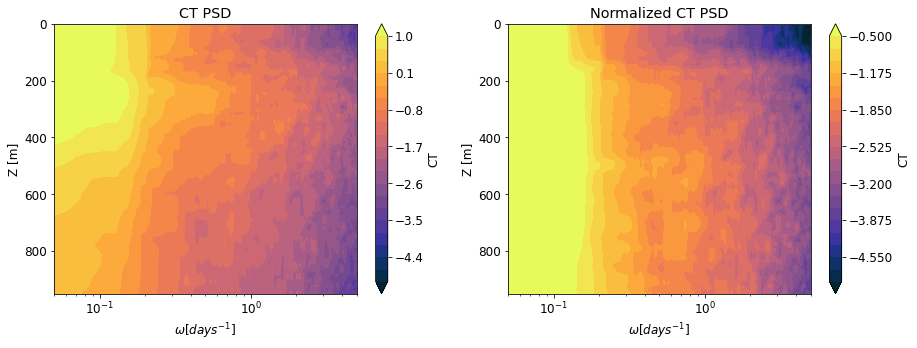

In [555]:
plt.figure(figsize=(13,5))
plt.subplot(121)
np.log10(ds_660_freq.CT).plot.contourf(levels=np.linspace(-5, 1, 21), cmap=cmo.thermal)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('CT PSD')

plt.subplot(122)
np.log10((ds_660_freq.CT / ds_660_freq.CT.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21) , cmap=cmo.thermal)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized CT PSD')

plt.tight_layout()
plt.savefig('figures/CT_depth_spec.pdf')

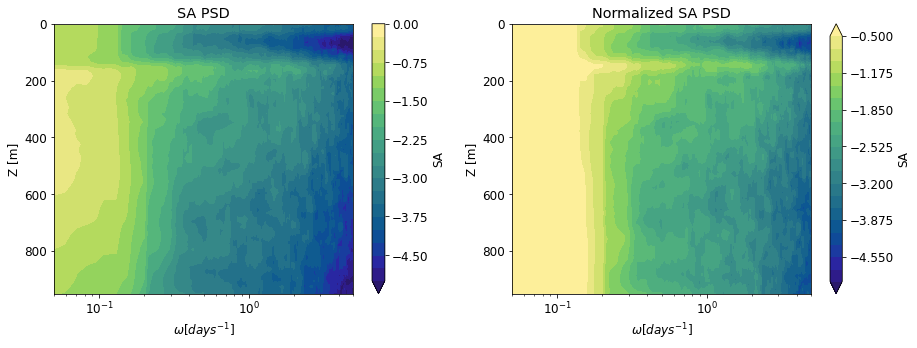

In [556]:
plt.figure(figsize=(13,5))
plt.subplot(121)
np.log10(ds_660_freq.SA).plot.contourf(levels=np.linspace(-5, 0, 21), cmap=cmo.haline)
plt.xscale('log')
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('SA PSD')

plt.subplot(122)
np.log10((ds_660_freq.SA / ds_660_freq.SA.max('freq'))).plot.contourf(levels=np.linspace(-5, -0.5, 21), cmap=cmo.haline)
plt.xscale('log')
plt.vlines([1/15/3600, 1/12/3600, 1/24/3600], 0, 1000, linestyles='--', colors='r', linewidths=.7)
plt.xlim([1/20, 5])
plt.ylim([0, 950])
plt.gca().invert_yaxis()
plt.ylabel('Z [m]')
plt.xlabel('$\omega [days^{-1}]$')
plt.title('Normalized SA PSD')

plt.tight_layout()
plt.savefig('figures/SA_depth_spec.pdf')